In [1]:
import sys
import gc

import fastai
from fastai.vision.all import *
from timm import create_model

from efficientnet_pytorch import EfficientNet

In [2]:
SEED=42
BATCH_SIZE = 32

set_seed(SEED, reproducible=True)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

In [3]:
dataset_path = Path('../input/MMU2/')

In [4]:
fnames = get_image_files(dataset_path)

In [5]:
def label_func(x): return x.parent.name

In [11]:
dls = ImageDataLoaders.from_path_func(dataset_path, 
                                      fnames, 
                                      label_func,
                                      seed=SEED,
                                      bs=BATCH_SIZE,
                                      num_workers=8,
                                      item_tfms=[Resize((460), method=ResizeMethod.Crop)], #pass in item_tfms
                                      batch_tfms=aug_transforms(size=224, min_scale=0.75)) #pass in batch_tfms

/home/orangel/miniconda3/envs/torch/lib/python3.8/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068694/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


In [12]:
dls.c

100

In [13]:
# model = create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=dls.c)
model = create_model('efficientnet_b0', pretrained=True, num_classes=dls.c)

In [14]:
learn = Learner(dls, 
                model,
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropyFlat(), 
                metrics=accuracy)

SuggestedLRs(valley=0.0012022644514217973)

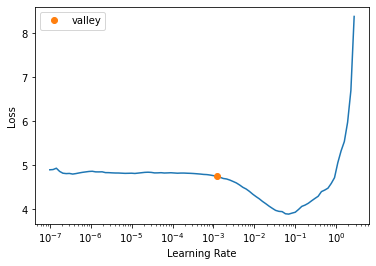

In [15]:
learn.lr_find()

In [16]:
learn.fit_one_cycle(n_epoch = 3, 
                lr_max  = 1e-3, 
                div     = 5,
                pct_start=0.0)

learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,4.631143,4.632338,0.045226,00:04
1,4.135649,4.272162,0.125628,00:04
2,3.758648,3.865157,0.246231,00:04


epoch,train_loss,valid_loss,accuracy,time
0,3.349003,3.499569,0.366834,00:04
1,3.233996,3.336611,0.437186,00:04
2,3.110008,3.158007,0.537688,00:04
3,2.972135,2.951102,0.597990,00:04
4,2.778601,2.711468,0.678392,00:04
5,2.590839,2.469658,0.733668,00:04
6,2.378947,2.269018,0.793970,00:04
7,2.163189,2.010897,0.824121,00:04
8,1.967768,1.792227,0.854271,00:04
9,1.768898,1.618406,0.864322,00:04


Better model found at epoch 0 with valid_loss value: 3.4995687007904053.
Better model found at epoch 1 with valid_loss value: 3.336611032485962.
Better model found at epoch 2 with valid_loss value: 3.1580069065093994.
Better model found at epoch 3 with valid_loss value: 2.951101541519165.
Better model found at epoch 4 with valid_loss value: 2.711467742919922.
Better model found at epoch 5 with valid_loss value: 2.4696576595306396.
Better model found at epoch 6 with valid_loss value: 2.2690181732177734.
Better model found at epoch 7 with valid_loss value: 2.010896921157837.
Better model found at epoch 8 with valid_loss value: 1.7922271490097046.
Better model found at epoch 9 with valid_loss value: 1.6184064149856567.
Better model found at epoch 10 with valid_loss value: 1.4678875207901.
Better model found at epoch 11 with valid_loss value: 1.3401302099227905.
Better model found at epoch 12 with valid_loss value: 1.2500312328338623.
Better model found at epoch 13 with valid_loss value: 1

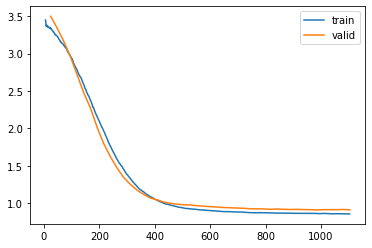

In [17]:
learn.fit_one_cycle(n_epoch=51, 
                    lr_max=slice(1e-7,1e-4), 
                    div=50, 
                    pct_start=0.0, 
                    cbs = [
                           SaveModelCallback(fname=f'best_model',monitor='valid_loss'),
                           EarlyStoppingCallback(monitor='valid_loss', comp=np.less, patience=5),
                           ReduceLROnPlateau(monitor='valid_loss', 
                                             min_delta=0.1, 
                                             patience = 3, 
                                             min_lr = 1e-8)])

learn.recorder.plot_loss()

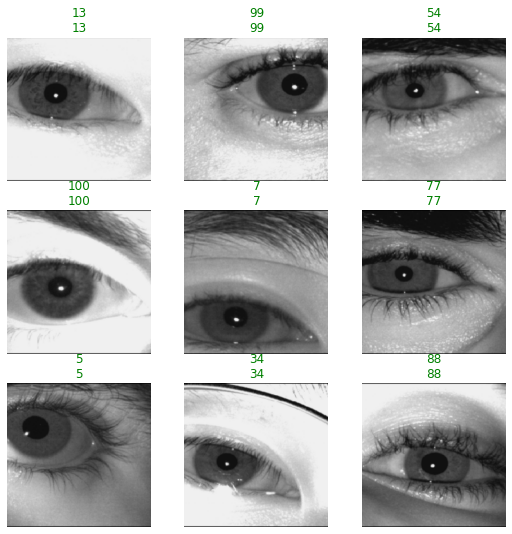

In [18]:
learn.show_results()

In [19]:
learn.load('best_model')
learn = learn.to_fp32()

learn.export(f'./model_EffiNetB0_0.964824.pkl')
learn.save(f'./model_EffiNetB0_0.964824.pkl')

/home/orangel/miniconda3/envs/torch/lib/python3.8/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Path('../input/MMU2/models/model_EffiNetB0_0.964824.pkl.pth')

In [20]:
del learn

torch.cuda.empty_cache()

gc.collect()

26773